# **Hierarchical Reconciliation**
**Hierarchical Time Series**

A time series is considered hierarchical when lower levels within the hierarchy only fall under one domain.

https://towardsdatascience.com/forecast-reconciliation-in-python-8203c16254b2 

# Installing Darts Library and Regraded Version of Matplotlib
Could not use Darts Library with the current version of Matplotlib - 3.5.3

Had to degrade to version - 3.1.3

https://stackoverflow.com/questions/64862818/cannot-import-name-png-from-matplotlib

In [1]:
! pip install darts
! pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 5.2 MB/s 
     |████████████████████████████████| 76.8 MB 2.1 MB/s 
     |████████████████████████████████| 708 kB 53.3 MB/s 
     |████████████████████████████████| 9.8 MB 45.0 MB/s 
     |████████████████████████████████| 1.8 MB 38.1 MB/s 
     |████████████████████████████████| 11.2 MB 46.8 MB/s 
     |████████████████████████████████| 43 kB 2.6 MB/s 
     |████████████████████████████████| 77 kB 6.4 MB/s 
     |████████████████████████████████| 569 kB 58.4 MB/s 
     |████████████████████████████████| 1.6 MB 53.5 MB/s 
     |████████████████████████████████| 965 kB 48.9 MB/s 
     |████████████████████████████████| 529 kB 54.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2
  Attempting uninstall: matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 5.2 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nfoursid 1.0.1 requires matplotlib>=3.3, but you have matplotlib 3.1.3 which is incompatible.
darts 0.22.0 requires matplotlib>=3.3.0, but you have matplotlib 3.1.3 which is incompatible.


# Necessary Imports for the Project

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from itertools import product

from darts import TimeSeries, concatenate
from darts.datasets import AustralianTourismDataset
from darts.models import LinearRegressionModel, Theta
from darts.metrics import mae
from darts.dataprocessing.transformers import MinTReconciliator

# Loading Dataset
**AustralianTourismDataset**

Australian tourism dataset contains monthly tourism numbers, disaggrated by region, travel reason and city/non-city type of tourism.

In [3]:
tourism_series = AustralianTourismDataset().load()

This series contains several components:

*   One component named "Total",
*   One component per region ("NSW", "VIC", etc)
*   One component per tourism reason ("Hol" for holiday, "Bus" for business, etc)
*   One component per (region, reason) pair (named "NSW - hol", "NSW - bus", etc)
*   One component per (region, reason, <city>) tuple, where <city> is either "city" or "noncity". So these are components named "NSW - hol - city", "NSW - hol - noncity", "NSW - bus - city", etc.




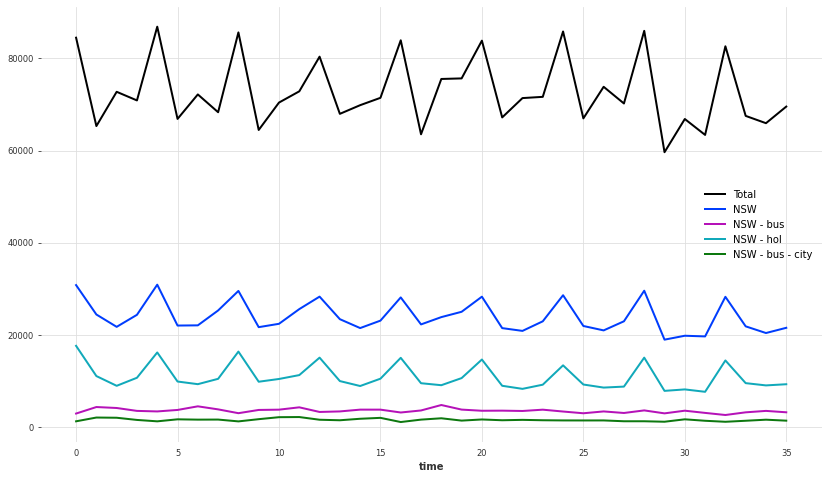

In [16]:
plt.figure(figsize=(14, 8))
tourism_series[["Total", "NSW", "NSW - bus", "NSW - hol", "NSW - bus - city"]].plot()

# Inspecting the Hierarchy

The sum of the holiday tourism done in New South Wales can be decomposed as the sum of “city” and “noncity” holiday New South Wales tourism.

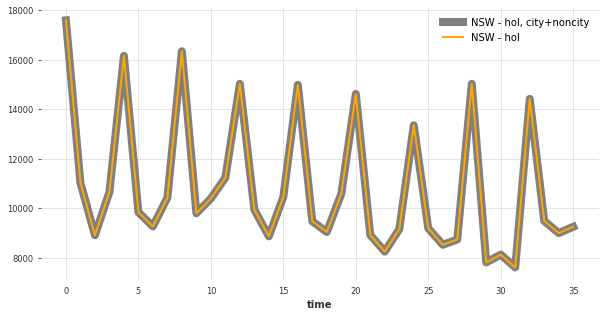

In [18]:
sum_city_noncity = (
    tourism_series["NSW - hol - city"] + tourism_series["NSW - hol - noncity"]
)
plt.figure(figsize=(10, 5))
sum_city_noncity.plot(label="NSW - hol, city+noncity", lw=8, color="grey")
tourism_series["NSW - hol"].plot(color="orange")

The sum of both over regions and over reasons add up to the total.

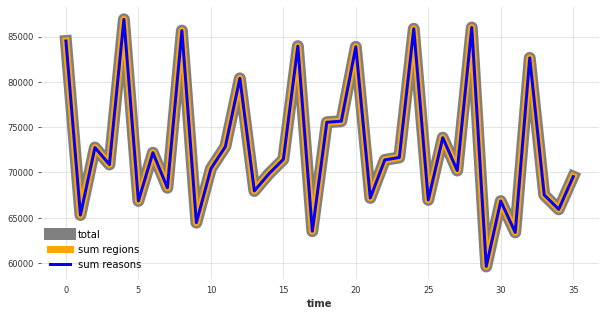

In [20]:
reasons = ["Hol", "VFR", "Bus", "Oth"]
regions = ["NSW", "VIC", "QLD", "SA", "WA", "TAS", "NT"]
city_labels = ["city", "noncity"]

plt.figure(figsize=(10, 5))
tourism_series["Total"].plot(label="total", lw=12, color="grey")
sum([tourism_series[region] for region in regions]).plot(
    label="sum regions", lw=7, color="orange"
)
sum([tourism_series[reason] for reason in reasons]).plot(
    label="sum reasons", lw=3, color="blue"
)


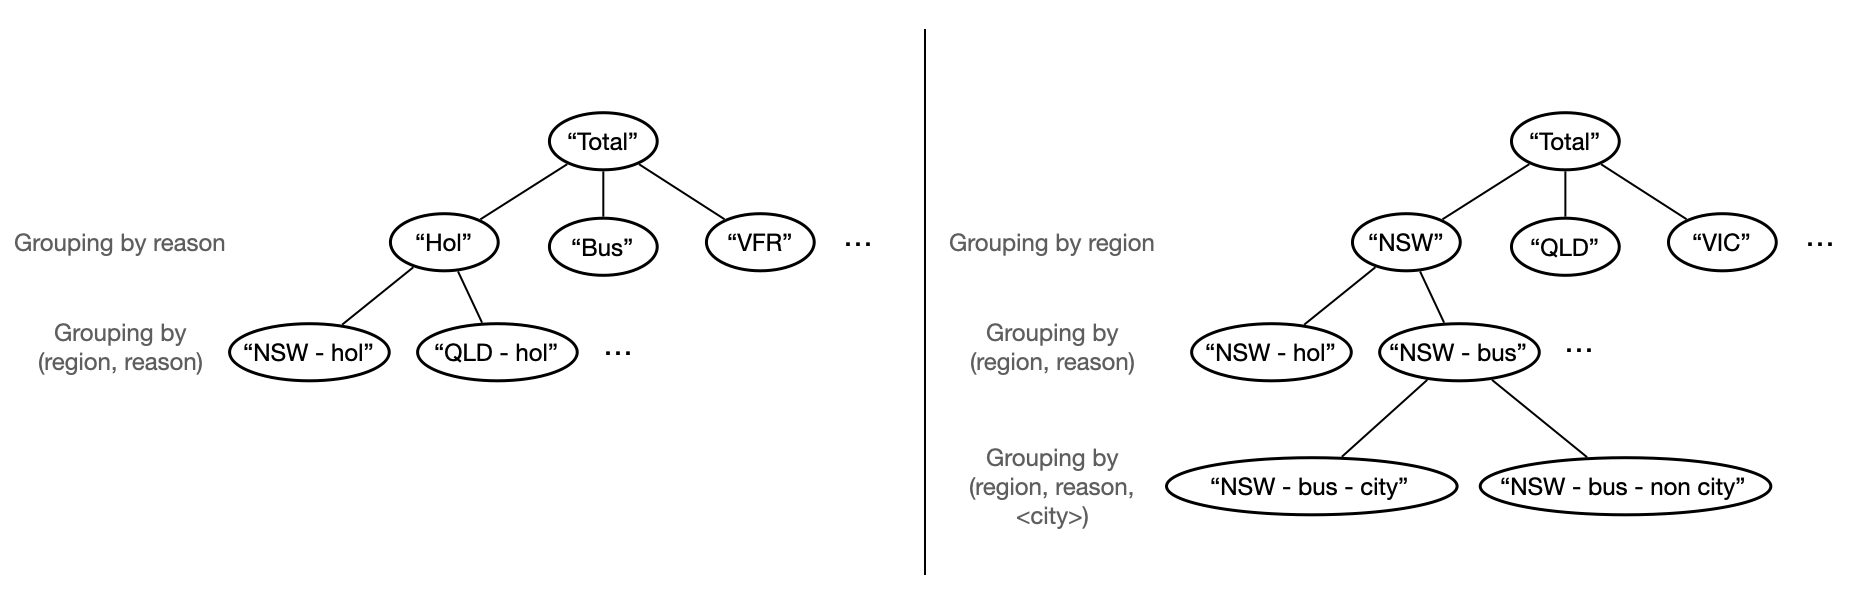

# Encoding the Hierarchy
The **Hierarchy in Darts** is simply represented as a **dict**, where the keys are component names, and the values are lists containing this component’s parent(s) in the hierarchy.

For example, referring to the figure above:


*   "Hol" is mapped to ["Total"], as it is a child of "Total" in the left tree.
*   "NSW - hol" is mapped to ["Hol", "NSW"], as it is a child of both "Hol" (in the left tree), and "NSW" (in the right tree).
*   "NSW - bus - city" is mapped to ["NSW - bus"] as it is a child of "NSW - bus" in the right tree.
*   etc…

So all components except "Total" will appear as a key in the hierarchy dictionary.

In [7]:
hierarchy = dict()

# Fill in grouping by reason
for reason in reasons:
    hierarchy[reason] = ["Total"]

# Fill in grouping by region
for region in regions:
    hierarchy[region] = ["Total"]

# Fill in grouping by (region, reason)
for region, reason in product(regions, reasons):
    hierarchy["{} - {}".format(region, reason.lower())] = [reason, region]

# Fill in grouping by (region, reason, <city>)
for region, reason, city in product(regions, reasons, city_labels):
    hierarchy["{} - {} - {}".format(region, reason.lower(), city)] = [
        "{} - {}".format(region, reason.lower())
    ]

for component in ["Hol", "NSW - hol", "NSW - bus - city"]:
    print(f"{component} -> {hierarchy[component]}")

Hol -> ['Total']
NSW - hol -> ['Hol', 'NSW']
NSW - bus - city -> ['NSW - bus']


In [8]:
# embed our hierarchy in our TimeSeries.
tourism_series = tourism_series.with_hierarchy(hierarchy)

# Forecasting Using a Multivariate Model
Darts models support multivariate series.

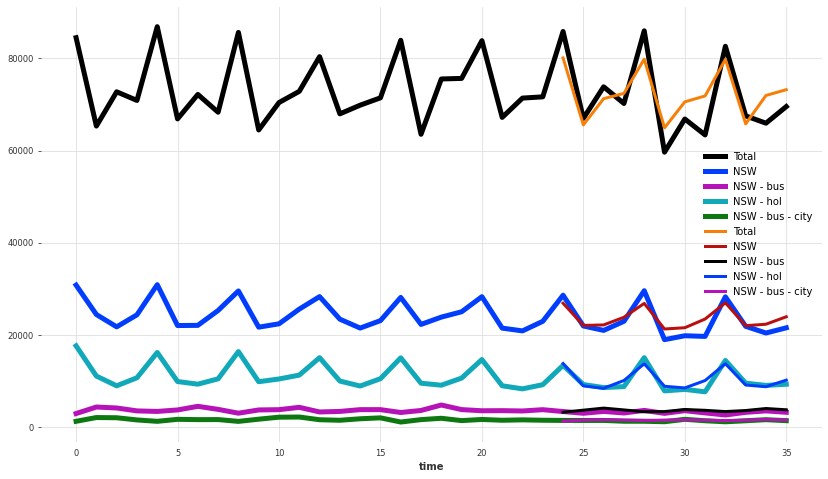

In [11]:
# split time series in train / eval parts keeping the last 12 months as a validation set
train, val = tourism_series[:-12], tourism_series[-12:]

model = LinearRegressionModel(lags=12)
model.fit(train)
pred = model.predict(n=len(val))

components_to_show = ["Total", "NSW", "NSW - bus", "NSW - hol", "NSW - bus - city"]
plt.figure(figsize=(14, 8))
tourism_series[components_to_show].plot(lw=5)
pred[components_to_show].plot(lw=3)

Computing the accuracy at the different levels:

In [12]:
# we pre-generate some of the components' names
regions_reasons_comps = list(
    map(lambda t: "{} - {}".format(t[0], t[1].lower()), product(regions, reasons))
)

regions_reasons_city_comps = list(
    map(
        lambda t: "{} - {} - {}".format(t[0], t[1].lower(), t[2]),
        product(regions, reasons, city_labels),
    )
)


def measure_mae(pred):
    def print_mae_on_subset(subset, name):
        print(
            "mean MAE on {}: {:.2f}".format(
                name,
                mae(
                    [pred[c] for c in subset],
                    [val[c] for c in subset],
                    inter_reduction=np.mean,
                ),
            )
        )

    print_mae_on_subset(["Total"], "total")
    print_mae_on_subset(reasons, "reasons")
    print_mae_on_subset(regions, "regions")
    print_mae_on_subset(regions_reasons_comps, "(region, reason)")
    print_mae_on_subset(regions_reasons_city_comps, "(region, reason, city)")


measure_mae(pred)

mean MAE on total: 4149.16
mean MAE on reasons: 1283.85
mean MAE on regions: 800.39
mean MAE on (region, reason): 312.59
mean MAE on (region, reason, city): 190.07


# Reconciling Forecasts
The concept of Forecast Reconciliation is a process by which independently generated forecasts of a collection of linearly related time series are reconciled via the introduction of accounting aggregations that naturally apply to the data.

https://www.sciencedirect.com/science/article/abs/pii/S0377221721000199

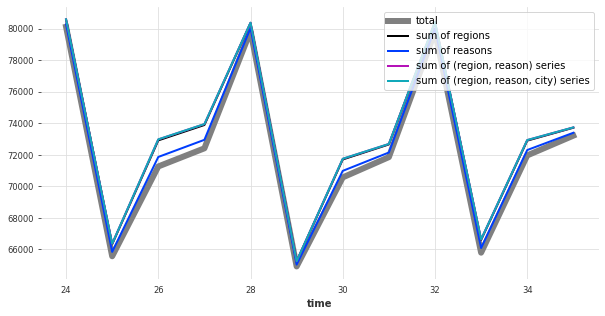

In [13]:
def plot_forecast_sums(pred_series):
    plt.figure(figsize=(10, 5))

    pred_series["Total"].plot(label="total", lw=6, alpha=0.3, color="grey")
    sum([pred_series[r] for r in regions]).plot(label="sum of regions")
    sum([pred_series[r] for r in reasons]).plot(label="sum of reasons")
    sum([pred_series[t] for t in regions_reasons_comps]).plot(
        label="sum of (region, reason) series"
    )
    sum([pred_series[t] for t in regions_reasons_city_comps]).plot(
        label="sum of (region, reason, city) series"
    )

    legend = plt.legend(loc="best", frameon=1)
    frame = legend.get_frame()
    frame.set_facecolor("white")


plot_forecast_sums(pred)

The current “raw” forecasts don't add up. So let’s reconcile them. 
Transformers available in darts.dataprocessing.transformers will be used to do that. These transformers can perform posthoc reconciliation (i.e., reconcile forecasts after they have been obtained). Rhe following methods are available:


*   BottomUpReconciliator performs bottom-up reconciliation, simply resetting each component in the hierarchy as the sum of its children components.
*   TopDownReconciliator performs top-down reconciliation, which breaks down the aggregate forecasts down the hierarchy using historical proportions. This transformer requires calling fit() with the historical values (i.e., the training series) in order to learn these proportions.
*   MinTReconciliator is a technique to perform “optimal” reconciliation.








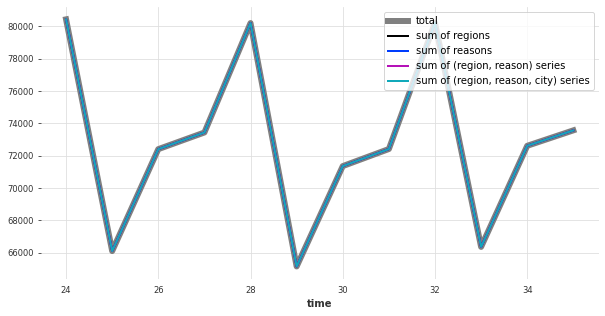

In [14]:
reconciliator = MinTReconciliator(method="wls_val")
reconciliator.fit(train)
reconcilied_preds = reconciliator.transform(pred)

plot_forecast_sums(reconcilied_preds)